This file is to try SBI_SGM 

And I train model with a general connectome.


### import and define

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

#### My own pkgs

In [4]:
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from utils.reparam import theta_raw_2out, normcdf_np, normcdf_torch, logistic_np, logistic_torch
from utils.stable import paras_table_check
from sgm.sgm import SGM
from spectrome import Brain, path, functions
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT
from models.embedding_nets import SummaryNet

In [5]:
#torch.set_default_tensor_type(torch.DoubleTensor)

### Load real data PSD and brain

#### PSD and connectome

In [6]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

In [7]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

In [8]:
from torch.distributions.multivariate_normal import MultivariateNormal
import torch
from models.embedding_nets import SummaryNet
from utils.standardize import psd_2tr, stdz_vec
from utils.misc import save_pkl, load_pkl
class sbi_sgm():
    def __init__(self, sgmmodel, save_folder=None, **input_params):
        
        
        # default params
        params = edict()
        
        # noise level added to SGM output
        params.noise_sd = 0.20
        # num of sbi sps to train the NN
        params.num_prior_sps = int(1e4)
        # the density estimator
        params.den_est = "nsf"
        # whether using a embed net to reduce the output dim or not
        params.is_embed = False
        # the sd of Gaussian prior for SBI
        params.prior_sd = 10
        
        # the parameter to control how to reparam the SGM parameters
        params.k = 0.1
        
        # the default SGM parameters bds with order in params.names
        params.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]
        par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
        par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
        params.prior_bds = np.array([par_low, par_high]).T
        
        for key in input_params.keys():
            if key not in params.keys():
                logger.warning(f"Plz check your input {key}, it is not used.")
            else:
                params[key] = input_params[key]
        if "prior_sd" in input_params.keys() or "k" in input_params.keys():
            logger.warning(f"k control the reparam of SGM. "
                           f"The default value is compatible with prior_sd."
                           f"Be careful if you change k or prior_sd."
                          )
        
        self.params = params
        logger.info(f"In this class, the sgm parameter order is {self.params.names}.")
        logger.info(self.params)
        
        
        if isinstance(save_folder, str):
            self.save_path = RES_ROOT/save_folder
        elif save_folder:
            self.save_path = RES_ROOT/(f"./sbi-sgm_results_numsps{paras.num_prior_sps:.0f}" +
                                      f"_sd{paras.noise_sd*100:.0f}" +
                                      f"_denest{paras.den_est}" +
                                      f"_embed{paras.is_embed}")
        else:
            self.save_path = None
        if self.save_path is not None:
            if not self.save_path.exists():
                self.save_path.mkdir()
        if self.save_path is None:
            logger.info(f"Results will not be saved.")
        else:
            logger.info(f"Results will be saved at {self.save_path}.")
            
        
        self.init_prior = MultivariateNormal(loc=torch.zeros(7), 
                                             covariance_matrix=torch.eye(7)*(self.params.prior_sd**2))
            
        self._trans_fn=partial(logistic_torch, k=self.params.k)
        self._reparam_fn = partial(theta_raw_2out, map_fn=partial(logistic_torch, k=self.params.k))
        
        self.sgmmodel = sgmmodel
        self.posterior = None
        self.embedding_net = None
        self.curX = None
        self.post_sps = None
        
        assert not self.params.is_embed, f"The embed network is not fully test!! If using, comment out this sentence."
        if self.params.is_embed:
            self.embedding_net = SummaryNet(num_in_fs=68*41)
            self.params.den_est = sutils.posterior_nn(model=self.params.den_est, 
                                                      embedding_net=self.embedding_net)
            
        
    def simulator(self, sgm_reparams, is_train=True):
        """ Generate data with SGM model
            args:
                is_train: (bool) if True, generating SGM data with noise (for training)
                                 if False, generating clean SGM data (no noise, for inference)
                    
        """
        sgm_params = (self._trans_fn(sgm_reparams)*(self.params.prior_bds[:, 1]-self.params.prior_bds[:, 0]) +
                       self.params.prior_bds[:, 0])
        #sgm_params = self._reparam_fn(sgm_reparams, self.params.prior_bds)
        psd, spatialFs = self.sgmmodel.run_local_coupling_forward(sgm_params)
        psd = psd[:68, :]
        
        sp_fs= spatialFs.sum(axis=1)
        if is_train: 
            sp_fs = stdz_vec(sp_fs) # std it
        
        std_psd_DB = psd_2tr(psd)
        psd_fs = std_psd_DB.flatten()
        
        res = np.concatenate([psd_fs, sp_fs]) 
        if is_train:
            noise =  np.random.randn(*res.shape)*self.params.noise_sd 
        else:
            noise = np.zeros_like(res)
        
        return res+noise
    
    def _filter_unstable(self, theta_raw, x=None):
        """This fn is to remove unstable SGM parameters
            args: theta_raw: parameters: num of sps x dim
                    order: ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei']
        """
        theta = self._reparam_fn(theta_raw, self.params.prior_bds)
        stable_idxs = paras_table_check(theta.numpy())
        
        # keep stable sps only
        theta_raw_stable = theta_raw[stable_idxs==0]
        if x is not None:
            x_stable = x[stable_idxs==0]
            return theta_raw_stable, x_stable
        else:
            return theta_raw_stable
    
    def SBI_fit(self, load=False):
        if not load:
            simulator_wrapper, prior = prepare_for_sbi(self.simulator, self.init_prior)
            sgm_reparamss, x = simulate_for_sbi(simulator_wrapper, prior, 
                                            num_simulations=int(self.params.num_prior_sps), 
                                            num_workers=20)
            sgm_reparamss_stable, x_stable = self._filter_unstable(sgm_reparamss, x)
            inference = SNPE(prior=prior, density_estimator=self.params.den_est)
            density_estimator = inference.append_simulations(sgm_reparamss_stable, x_stable).train()
            posterior = inference.build_posterior(density_estimator)
            self.posterior = posterior
            if self.save_path is not None:
                save_pkl(self.save_path/"posterior.pkl", self.posterior, is_force=True)
        else:
            assert (self.save_path/"posterior.pkl").exists(), "No file to load!!"
            self.posterior = load_pkl(self.save_path/"posterior.pkl")
        
    def add_data(self, psd):
        """psd: nroi x nfreq
        """
        # only get spatial feature from alpha band
        freqband = np.where((self.sgmmodel.freqs>=8) & (self.sgmmodel.freqs<=12))[0]
        raw_sps = psd[:, freqband]
    
        std_spv = stdz_vec(raw_sps.sum(axis=1))
        std_psd_DB = psd_2tr(psd)
        curX_raw = np.concatenate([std_psd_DB.flatten(), std_spv])
        self.curX = torch.Tensor(curX_raw)
        
        # if add a data, clean the previous sps
        self.post_sps = None
    
    def get_post_sps(self, n=10000):
        assert self.posterior is not None, "Train SBI first with SBI_fit()"
        assert self.curX is not None, "You should add data first with add_data(psd)"
        
        post_sps_reparam = self.posterior.sample((n, ), x=self.curX, max_sampling_batch_size=100)
        
        # only keep stable params
        post_sps_reparam = self._filter_unstable(post_sps_reparam)
        self.post_sps = self._reparam_fn(post_sps_reparam, self.params.prior_bds) 
        return self.post_sps
        
    def get_model_psd_sp(self):
        assert self.post_sps is not None, "You should get posterior sps with get_post_sps(n)"
        pt_est = np.median(self.post_sps, axis=0)
        cur_psd, cur_sp = self.sgmmodel.run_local_coupling_forward(pt_est)
        cur_psd = cur_psd[:68, :]
        cur_psd_DB = psd_2tr(cur_psd)
        return cur_psd_DB, cur_sp.sum(axis=1)
        

    def get_post_psd_sps(self, n=100):
        """You only need it when you want a Full-Bayesian inference.
        """
        assert self.posterior is not None, "Train SBI first with SBI_fit()"
        assert self.curX is not None, "You should add data first with add_data(psd, sc)"
        simulator_data_sp = partial(self.simulator, is_train=False)
        simulator_data_wrapper, _ = prepare_for_sbi(simulator_data_sp, self.init_prior)
        cur_post = self.posterior.set_default_x(self.curX)
        
        tmp_sps, post_psd = simulate_for_sbi(simulator_data_wrapper, cur_post, 
                            num_simulations=n,
                            num_workers=20)
        
        _, post_psd_stable = self._filter_unstable(tmp_sps, post_psd)
        self.post_psd = post_psd_stable[:, :-68].reshape(-1, 68, len(self.sgmmodel.freqs)).numpy()
        return self.post_psd

In [24]:
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)
SBI_SGM = sbi_sgm(sgmmodel, save_folder="Test",  num_prior_sps=1000)

2023-12-04 21:48:09,364 - __main__ - INFO - {'noise_sd': 0.2, 'num_prior_sps': 1000, 'den_est': 'nsf', 'is_embed': False, 'prior_sd': 10, 'k': 0.1, 'names': ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei'], 'prior_bds': array([[5.e-03, 3.e-02],
       [5.e-03, 2.e-01],
       [5.e-03, 3.e-02],
       [5.e+00, 2.e+01],
       [1.e-01, 1.e+00],
       [1.e-03, 2.e+00],
       [1.e-03, 7.e-01]])}
2023-12-04 21:48:09,370 - __main__ - INFO - Results will be saved at /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/Test.


In [10]:
SBI_SGM.SBI_fit(load=False)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 29 epochs.Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/Test/posterior.pkl


In [11]:
SBI_SGM.add_data(ind_psd[:, :, 0])

In [12]:
SBI_SGM.get_post_sps();

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
psd, sp = SBI_SGM.get_model_psd_sp();

In [14]:
SBI_SGM.get_post_psd_sps();

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

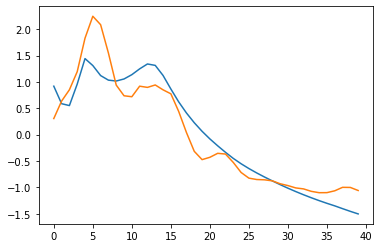

In [23]:
plt.plot(stdz_vec(psd.mean(axis=0)))
plt.plot(stdz_vec(ind_psd[:, :, 0].mean(axis=0)))
